In [238]:
import pandas as pd
import os, sys
from collections import Counter
import geopandas as gpd
import pylab as pl
from fiona.crs import from_epsg
import shapely 
import seaborn as sns
from shapely.geometry import Point
import pyproj

% pylab inline

Populating the interactive namespace from numpy and matplotlib


# Turn RDD output into orderly dataframe

In [464]:
df = pd.read_csv('/Users/shay/CUSP/BDM/results.csv', index_col = 0)
df.columns = ['Date_Hour', 'Results']

df['Results'] = df['Results'].apply(lambda x: eval(x))

final = pd.DataFrame()
for row in range(len(df)):
    tempdf = pd.DataFrame.from_dict(df.Results[row], orient = 'index')
    tempdf.reset_index(inplace = True)
    tempdf.columns = ['Station', 'Taxi_Rides']
    tempdf['Date_Hour'] = df.Date_Hour[row]
    final = final.append(tempdf)

final.reset_index(inplace = True, drop=True)
final['Date'] = final['Date_Hour'].apply(lambda x: x.split(', ')[0][1:])
final['Hour'] = final['Date_Hour'].apply(lambda x: x.split(', ')[1][:-1])
final['Station'] = final['Station'].convert_objects(convert_numeric = True)
final['Station'] = final['Station'].apply(lambda x: int(x))
final.drop('Date_Hour', axis = 1, inplace = True)

final.to_csv('finaldf.csv')

/Users/shay/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


# Merge with subway delay data

In [159]:
df95 = pd.read_csv('/Users/shay/CUSP/BDM/subway_taxi_project/data/delay_final_975.csv')

final['keycol'] = final.Station.map(lambda x: str(x) + '_') + \
                final.Date.map(lambda x: str(x) + '_') + \
                final.Hour.map(lambda x: str(x))

df95['keycol'] = df95.station.map(lambda x: str(x) + '_') + \
                df95.date.map(lambda x: str(x) + '_') + \
                df95.start_hr.map(lambda x: str(x))

merged = final.merge(df95, left_on = 'keycol', right_on = 'keycol', how = 'right')

merged.set_index('keycol', inplace = True)

# Read in subway shapefile, create 300 foot buffer

In [160]:
filepath = '/Users/shay/CUSP/BDM/subway_taxi_project/data/subwaystations/subwaystations.shp'
subwayst = gpd.read_file(filepath)

In [161]:
subwayst.crs = from_epsg(4326)
subwayst = subwayst.to_crs(epsg = 2263)

In [265]:
subwayst['buffer'] = subwayst.geometry.apply(lambda x: x.buffer(300))
subwayst.set_geometry('buffer', crs = 2263, inplace = True)

# Attach shapes to DataFrame

In [266]:
subwayst.objectid = subwayst.objectid.map(lambda x: int(x))

In [267]:
subwaytaxi = subwayst.merge(final, left_on = 'objectid', right_on = 'Station', how = 'right')

# Some Visualizations

In [268]:
viz_df = subwaytaxi.groupby('Station').mean()
viz_df = viz_df.merge(subwayst)

In [269]:
viz_df.drop(['geometry', 'notes', 'url'], axis = 1, inplace = True)

In [270]:
viz_df = gpd.GeoDataFrame(viz_df, geometry = 'buffer')

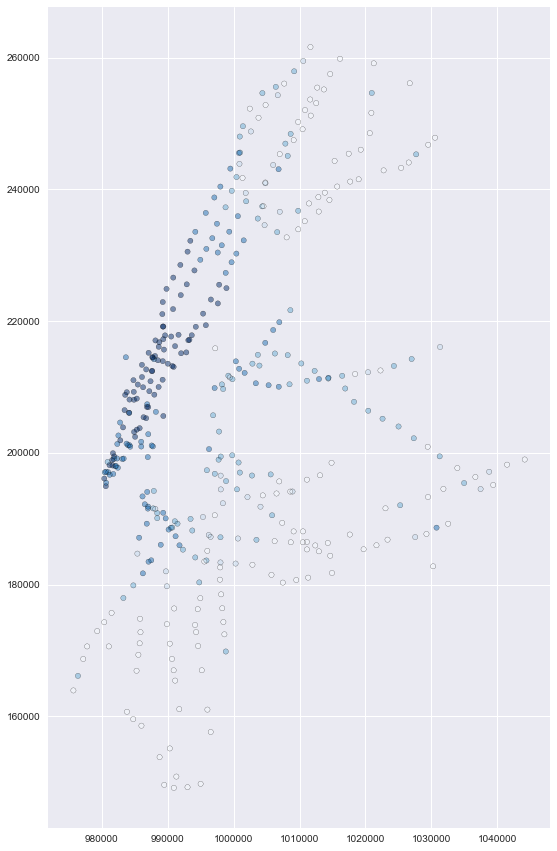

In [271]:
viz_df.plot('Taxi_Rides', figsize = (9, 20), cmap = cm.Blues, scheme = 'percentages', linewidth = .2)

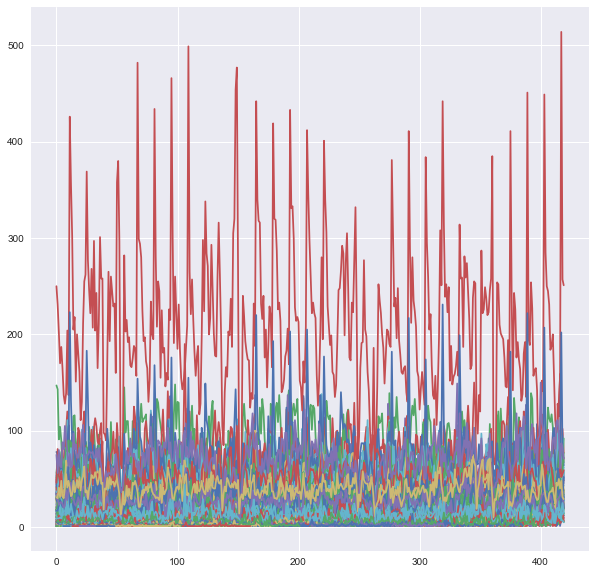

In [272]:
subwaytaxi.sort_values(['Date', 'Hour'], inplace = True)
fig = pl.figure(figsize(10, 10))
for station in subwaytaxi.objectid.unique():
    filterd = subwaytaxi[subwaytaxi.objectid == station]
    pl.plot(range(len(filterd)), filterd.Taxi_Rides, label = filterd.name.iloc[0])

In [273]:
avgsdf = subwaytaxi.groupby('name').mean().sort_values('Taxi_Rides', ascending = False)

In [274]:
delays = subwayst.merge(merged, left_on = 'objectid', right_on = 'Station', how = 'right')

In [275]:
withdelays = delays[delays.delay > 0].groupby('name')[['Taxi_Rides', 'name']].mean().sort_values('Taxi_Rides', ascending = False)

In [276]:
nodelays = delays[delays.delay == 0].groupby('name')[['Taxi_Rides', 'name']].mean().sort_values('Taxi_Rides', ascending = False)

In [277]:
comparison = withdelays.merge(nodelays, left_index = True, right_index = True, suffixes = ('_with', '_without'))

In [278]:
comparison[comparison.Taxi_Rides_with > comparison.Taxi_Rides_without]

,Taxi_Rides_with,Taxi_Rides_without
name,,
Grand Central - 42nd St,58.823944,56.382671
8th St - NYU,24.540000,23.975477
W 4th St - Washington Sq (Upper),25.178010,22.114537
Canal St - Holland Tunnel,18.384615,16.197232
Wall St,9.537037,8.453074
Cathedral Pkwy (110th St),8.607143,8.092105
City Hall,7.116279,5.528409
Queensboro Plz,5.110092,5.003663
Fulton St,3.474510,3.396429


In [279]:
comparison[comparison.Taxi_Rides_with < comparison.Taxi_Rides_without]

,Taxi_Rides_with,Taxi_Rides_without
name,,
50th St,31.663158,32.777251
Astor Pl,25.878788,27.692593
South Ferry,19.351351,19.923313
World Trade Center,13.265823,14.973529
Bowling Green,13.550000,13.565625
Canal St,9.892157,10.239870
Chambers St,4.672131,4.747664
Delancey St - Essex St,4.261364,4.308824
46th St,2.698113,3.609137


In [280]:
sorted(df95.station.unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 101,
 103,
 104,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 201,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 301,
 302,
 401,
 402,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 418,
 419,
 420,
 423,
 501,
 502,
 503,
 504,
 505,
 601,
 602,
 603,
 604,
 606,
 607,
 608,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 616,
 617,
 618,
 619,
 621,
 622,
 623,
 624,
 625,
 626,
 627,
 628,
 629,
 630,
 631,
 632,
 633,
 634,
 635,
 

In [281]:
stationurl = 'https://mtaapi.herokuapp.com/stations'

In [282]:
import requests
import json
r = requests.get(stationurl)
stationlocations = json.loads(r.content)

In [283]:
ids = []
for i in stationlocations['result']: 
    ids.append(i['id'])

In [415]:
stationdict = {}
for i in ids: 
    baseurl = 'http://mtaapi.herokuapp.com/stop?id='
    r = requests.get(baseurl + i)
    res = json.loads(r.content) 
    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    stationdict[i] = (Point(proj(res['result']['lon'], res['result']['lat'])), res['result']['name'])

In [442]:
gtfssubway = pd.DataFrame.from_dict(stationdict, 'index')
gtfssubway.columns = ['geometry', 'station_name']

In [443]:
gtfssubway = gpd.GeoDataFrame(gtfssubway, geometry = 'geometry', crs = 2263)

In [444]:
gtfssubway.reset_index(inplace = True)

In [445]:
gtfssubway.columns = ['id', 'geometry', 'station_name']
gtfssubway = gtfssubway.set_geometry('geometry', crs = 2263)

In [446]:
gtfssubway['master'] = [''.join([x for x in z if x.isdigit()]) for z in gtfssubway['id']]

In [448]:
gtfssubway['objectid'] = gtfssubway.id.map(lambda x: int(x[1:3]))

In [453]:
gtfssubway.head()

,id,geometry,station_name,master,objectid
0,106S,POINT (1009186.66479808 257916.7472231909),Marble Hill - 225 St,106,6
1,S13N,POINT (920541.7709241894 128675.525925326),Richmond Valley,13,13
2,231S,POINT (986167.1925104588 193382.2031932339),Clark St,231,31
3,L21S,POINT (1010529.397394313 188063.6525612742),Bushwick Av - Aberdeen St,21,21
4,231N,POINT (986167.1925104588 193382.2031932339),Clark St,231,31


In [457]:
subwayst[subwayst.name.str.contains('Marble Hill')]

,geometry,line,name,notes,objectid,url,buffer
265,POINT (1009186.665009722 257916.7470113282),1,Marble Hill - 225th St,1-all times,266,http://web.mta.info/nyct/service/,"POLYGON ((1009586.303646583 257931.467313627, ..."


In [463]:
subwayst

,geometry,line,name,notes,objectid,url,buffer
0,POINT (986725.0019278985 205255.0527942391),4-6-6 Express,Astor Pl,"4 nights, 6-all times, 6 Express-weekdays AM s...",1,http://web.mta.info/nyct/service/,"POLYGON ((987124.6405647601 205269.7730965379,..."
1,POINT (984196.5000951464 201155.8398640769),4-6-6 Express,Canal St,"4 nights, 6-all times, 6 Express-weekdays AM s...",2,http://web.mta.info/nyct/service/,"POLYGON ((984596.1387320079 201170.5601663757,..."
2,POINT (988724.2161053148 216795.1908031626),1-2,50th St,"1-all times, 2-nights",3,http://web.mta.info/nyct/service/,"POLYGON ((989123.8547421764 216809.9111054614,..."
3,POINT (991184.2459621441 187333.8442141615),2-3-4,Bergen St,"4-nights, 3-all other times, 2-all times",4,http://web.mta.info/nyct/service/,"POLYGON ((991583.8845990057 187348.5645164603,..."
4,POINT (1013411.540746317 181467.289018167),3-4,Pennsylvania Ave,"4-nights, 3-all other times",5,http://web.mta.info/nyct/service/,"POLYGON ((1013811.179383179 181482.0093204658,..."
5,POINT (1011660.704024897 261601.4420697522),1,238th St,"1-all times, exit only northbound",6,http://web.mta.info/nyct/service/,"POLYGON ((1012060.342661759 261616.162372051, ..."
6,POINT (995859.7556399845 230953.2258072409),A-B-C,Cathedral Pkwy (110th St),"A-nights, B-weekdays and evenings, C-all times...",7,http://web.mta.info/nyct/service/,"POLYGON ((996259.3942768461 230967.9461095397,..."
7,POINT (1000653.603991895 186994.779931654),A-C,Kingston - Throop Aves,"A-nights, C-all other times",8,http://web.mta.info/nyct/service/,"POLYGON ((1001053.242628757 187009.5002339528,..."
8,POINT (1012293.106303393 212435.9029338322),E-M-R,65th St,"E-nights, R-all other times, M-weekdays and ev...",9,http://web.mta.info/nyct/service/,"POLYGON ((1012692.744940255 212450.623236131, ..."
9,POINT (1003916.554486977 213243.9620132558),E-M-R,36th St,"E-nights, R-all other times, M-weekdays and ev...",10,http://web.mta.info/nyct/service/,"POLYGON ((1004316.193123838 213258.6823155546,..."
